# <font color='DarkBlue'>Face Recognition

Many of the ideas presented here are from 
* [FaceNet](https://arxiv.org/pdf/1503.03832.pdf).
* [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf). 

Face recognition problems commonly fall into two categories: 

- **Face Verification** - "Is this the claimed person?". This is a `1:1` matching problem. 
- **Face Recognition**  - "Who is this person?". This is a `1:K` matching problem. 

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.
    
    
#### Channels-First notation

* A batch of images will be of shape $(m, n_C, n_H, n_W)$ instead of $(m, n_H, n_W, n_C)$.

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
from IPython.display import Image as inlineImage

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


## <font color='IndianRed'>Naive Face Verification

In the naive way, we compare the two images pixel-by-pixel. If the distance between the raw images are less than a chosen threshold, it may be the same person.

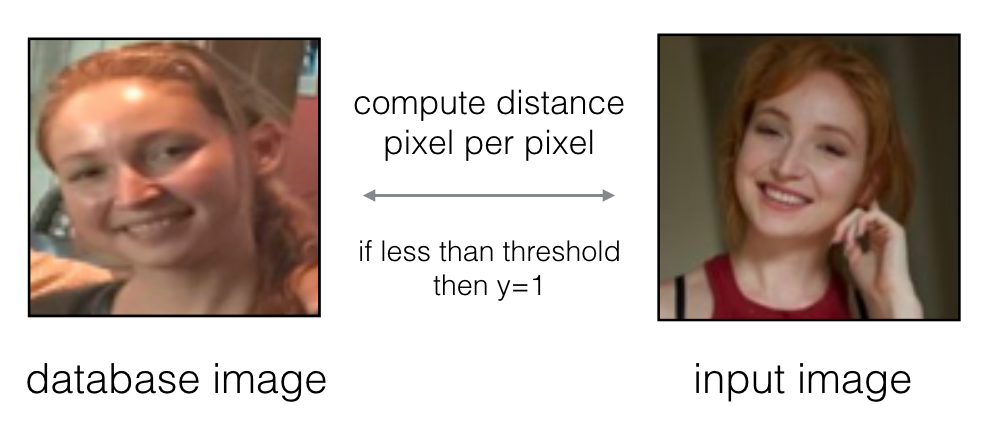

In [2]:
inlineImage('images/pixel_comparison.png', height=400, width = 650)

Of course, this algorithm performs really poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, even minor changes in head position etc. Rather than using the raw image, we can learn an encoding, $f(img)$. By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.

## <font color='Indianred'>Encoding images into a 128-dim vector

### <font color='Indigo'>CNN to compute encodings

The FaceNet model takes a lot of data and a long time to train. So following common practice in applied deep learning, we use pretrained weights. The network architecture follows the Inception model from [Szegedy et al](https://arxiv.org/abs/1409.4842). Inception Network implmentation is provided (`inception_blocks_v2.py`)

Key information:

- Network uses 96x96 dimensional RGB images as its input. Specifically, inputs a face image (or batch of $m$ face images) as a tensor of shape $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$ 
- It outputs a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

In [3]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [4]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. So, an encoding is a good one if: 
- The encodings of two images of the same person are quite similar to each other. 
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to push the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.

### <font color='Indigo'>The Triplet Loss</font>

For an image $x$, we denote its encoding as $f(x)$, where $f$ is the function computed by the neural network.

Training will use triplets of images $(A, P, N)$:  

- A is `Anchor` image, a picture of a person. 
- P is `Positive` image, a picture of the same person as the Anchor image.
- N is `Negative` image, a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{[1]} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{[2]} + \alpha \large ] \small_+$$

Here, we are using the notation $[z]_+$ to denote $max(z,0)$.  

***Notes***:
- The term [1] is the squared distance between the anchor A and the positive P for a given triplet; you want this to be small. 
- The term [2] is the squared distance between the anchor A and the negative N for a given triplet, you want this to be relatively large.
- $\alpha$ is called the margin. It is a hyperparameter that you pick manually. We will use $\alpha = 0.2$. 

[Most implementations also rescale the encoding vectors to haven L2 norm equal to one (i.e., $\mid \mid f(img)\mid \mid_2$=1)]

**Exercise**: Implement the triplet loss as defined. Here are the 4 steps:
1. Compute the distance between the encodings of anchor and positive: $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
2. Compute the distance between the encodings of anchor and negative: $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
3. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
3. Compute the full formula by taking the max with zero and summing over the training examples:
$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ $$

#### Hints
* Useful functions: `tf.reduce_sum()`, `tf.square()`, `tf.subtract()`, `tf.add()`, `tf.maximum()`.
* For steps 1 and 2, you will sum over the entries of $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$ and $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$.  

* Sum over all training examples.

* Recall that the square of the L2 norm is the sum of the squared differences: $||x - y||_{2}^{2} = \sum_{i=1}^{N}(x_{i} - y_{i})^{2}$
* Note that the `anchor`, `positive` and `negative` encodings are of shape `(m,128)`, where m is the number of training examples and 128 is the number of elements used to encode a single example.

In [5]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(anchor-positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor-negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

In [6]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    
    print("loss = " + str(loss.eval()))

loss = 528.143


## <font color='Indianred'>Loading the pre-trained model


In [7]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

## <font color='indianred'>Applying the model

### <font color='Indigo'>Face Verification </font>

Let's build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding we use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image. 

In [8]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

Now, when someone shows up at your front door and swipes their ID card (thus giving you their name), you can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

**Exercise**: Implement the `verify()` function which checks if the front-door camera picture (`image_path`) is actually the person called `identity`. You will have to go through the following steps:
1. Compute the encoding of the image from `image_path`.
2. Compute the distance between this encoding and the encoding of the identity image stored in the database.
3. Positive match if the distance is less than 0.7


* As presented above, you should use the L2 distance `np.linalg.norm`

#### Hints
* `identity` is a string that is also a key in the `database` dictionary.
* `img_to_encoding` has two parameters: the `image_path` and `model`.

In [9]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. 
    database -- python dictionary mapping names of allowed names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above.
    encoding = img_to_encoding(image_path, model)
    
    # Step 2: Compute distance with identity's image
    dist = np.linalg.norm(encoding-database[identity])
    print (dist)
    
    # Step 3: Open the door if dist < 0.7
    if (dist < 0.7):
        print("It's " + str(identity) + ", Welcome!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", Alert!")
        door_open = False
        
    return dist, door_open

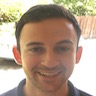

In [10]:
inlineImage('images/camera_0.jpg')

In [11]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

0.659393
It's younes, Welcome!


(0.65939289, True)

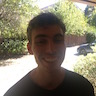

In [12]:
inlineImage("images/camera_2.jpg")

In [13]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

0.86224
It's not kian, Alert!


(0.86224014, False)

### <font color='Indigo'>Face Recognition</font>

You'll implement a face recognition system that takes as input an image, and figures out if it is one of the authorized persons (and if so, who). Unlike the previous face verification system, we will no longer get a person's name as one of the inputs. 

**Exercise**: Implement `who_is_it()`. You will have to go through the following steps:
1. Compute the target encoding of the image from image_path
2. Find the encoding from the database that has smallest distance with the target encoding. 
    - Initialize the `min_dist` variable to a large enough number (100). It will help you keep track of what is the closest encoding to the input's encoding.
    - Loop over the database dictionary's names and encodings. To loop use `for (name, db_enc) in database.items()`.
        - Compute the L2 distance between the target "encoding" and the current "encoding" from the database.
        - If this distance is less than the min_dist, then set `min_dist` to `dist`, and `identity` to `name`.

In [14]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
       
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding()
    encoding = img_to_encoding(image_path, model)
    
    ## Step 2: Find the closest encoding ##
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc
        dist = np.linalg.norm(encoding - db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if (dist < 0.7):
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("It is " + str(identity) + ", with score = " + str(min_dist))
        
    return min_dist, identity

In [15]:
who_is_it("images/camera_0.jpg", database, FRmodel)

It is younes, with score = 0.659393


(0.65939289, 'younes')

## <font color='IndianRed'>References</font>

- Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
- Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf) 
- The pretrained model inspired by Victor Sy Wang's implementation & loaded by: https://github.com/iwantooxxoox/Keras-OpenFace.
- FaceNet github repository: https://github.com/davidsandberg/facenet 